In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import hvplot.pandas

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [135]:
data = pd.read_csv("C:/Users/Mohammad Nahle/Downloads/Techlabs Data/AcceptedLoans.csv")

In [136]:
data['loan_status'] = data.loan_status.map({'Fully Paid':1, 'Charged Off':0})

In [137]:
print(f"The Length of the data: {data.shape}")

The Length of the data: (396030, 27)


In [138]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_title': number of missing values '22927' ==> '5.789%'
'emp_length': number of missing values '18301' ==> '4.621%'
'title': number of missing values '1756' ==> '0.443%'
'revol_util': number of missing values '276' ==> '0.070%'
'mort_acc': number of missing values '37795' ==> '9.543%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [139]:
data.emp_title.nunique()

173105

In [140]:
data.drop('emp_title', axis=1, inplace=True)

In [141]:
data.emp_length.unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [142]:
for year in data.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{data[data.emp_length == year].loan_status.value_counts(normalize=True)}")

10+ years years in this position:
loan_status
1   0.82
0   0.18
Name: proportion, dtype: float64
4 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
< 1 year years in this position:
loan_status
1   0.79
0   0.21
Name: proportion, dtype: float64
6 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
9 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
2 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
3 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
8 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
7 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
5 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
1 year years in this position:
loan_status
1   

In [143]:
data.drop('emp_length', axis=1, inplace=True)

In [144]:
data.title.value_counts().head()

title
Debt consolidation         152472
Credit card refinancing     51487
Home improvement            15264
Other                       12930
Debt Consolidation          11608
Name: count, dtype: int64

In [145]:
data.purpose.value_counts().head()

purpose
debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
Name: count, dtype: int64

In [146]:
data.drop('title', axis=1, inplace=True)

In [147]:
data.mort_acc.value_counts()

mort_acc
0.00     139777
1.00      60416
2.00      49948
3.00      38049
4.00      27887
5.00      18194
6.00      11069
7.00       6052
8.00       3121
9.00       1656
10.00       865
11.00       479
12.00       264
13.00       146
14.00       107
15.00        61
16.00        37
17.00        22
18.00        18
19.00        15
20.00        13
24.00        10
22.00         7
21.00         4
25.00         4
27.00         3
32.00         2
31.00         2
23.00         2
26.00         2
28.00         1
30.00         1
34.00         1
Name: count, dtype: int64

In [148]:
data.mort_acc.isna().sum()

37795

In [149]:
# Convert 'mort_acc' to a numeric data type, coercing errors to NaN
data['mort_acc'] = pd.to_numeric(data['mort_acc'], errors='coerce')

# Optionally, handle missing values by filling them or dropping them
# data['mort_acc'] = data['mort_acc'].fillna(0) # Example: Fill missing values with 0

# Now calculate the mean of 'mort_acc' grouped by 'total_acc'
total_acc_avg = data.groupby('total_acc')['mort_acc'].mean()

# To fill missing 'mort_acc' based on the averages by 'total_acc'
data['mort_acc'] = data.apply(
    lambda row: total_acc_avg[row['total_acc']] if pd.isnull(row['mort_acc']) else row['mort_acc'],
    axis=1
)

In [150]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [151]:
data['mort_acc'] = data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [152]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'revol_util': number of missing values '276' ==> '0.070%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [153]:
data.dropna(inplace=True)

In [154]:
data.shape

(395219, 24)

In [155]:
print([column for column in data.columns if data[column].dtype == object])

['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'earliest_cr_line', 'initial_list_status', 'application_type', 'address']


In [156]:
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [157]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

In [158]:
data.term.unique()

array([36, 60], dtype=int64)

In [159]:
data.drop('grade', axis=1, inplace=True)

In [160]:
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status', 
           'application_type', 'home_ownership']
data = pd.get_dummies(data, columns=dummies, drop_first=True)

In [161]:
data.address.head()

0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: address, dtype: object

In [162]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [163]:
data.zip_code.value_counts()

zip_code
70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: count, dtype: int64

In [164]:
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)

In [165]:
data.drop('address', axis=1, inplace=True)

In [166]:
data.drop('issue_d', axis=1, inplace=True)

In [167]:
# Convert 'earliest_cr_line' to datetime format
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce')

# Extract the year from the datetime
data['earliest_cr_line_year'] = data['earliest_cr_line'].dt.year

C:\Users\Mohammad Nahle\AppData\Local\Temp\ipykernel_10140\2863815111.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce')


In [168]:
data['earliest_cr_line'] = data.earliest_cr_line.dt.year


In [169]:
data.earliest_cr_line.nunique()


65

In [170]:
data.earliest_cr_line.value_counts()

earliest_cr_line
2000    29302
2001    29031
1999    26444
2002    25849
2003    23623
        ...  
1951        3
1950        3
1953        2
1944        1
1948        1
Name: count, Length: 65, dtype: int64

In [171]:
data.drop('earliest_cr_line', axis=1, inplace=True)


In [104]:
print(f"Data shape: {data.shape}")

## Remove duplicate Features
data = data.T.drop_duplicates()
data = data.T

# # Remove Duplicate Rows
data.drop_duplicates(inplace=True)

print(f"Data shape: {data.shape}")

Data shape: (395219, 81)
Data shape: (395219, 81)


In [172]:
# Calculate the weights using iloc for positional indexing
w_p = data['loan_status'].value_counts().iloc[0] / data.shape[0]
w_n = data['loan_status'].value_counts().iloc[1] / data.shape[0]

print(f"Weight of positive values {w_p}")
print(f"Weight of negative values {w_n}")

Weight of positive values 0.8038479931379817
Weight of negative values 0.19615200686201828


In [173]:
train, test = train_test_split(data, test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)

(264796, 81)
(130423, 81)


In [174]:
#Removing Outliers
print(train[train['dti'] <= 50].shape)
print(train.shape)


(264776, 81)
(264796, 81)


In [175]:
print(train.shape)
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]
print(train.shape)

(264796, 81)
(262143, 81)


In [176]:
#Normalizing the Data
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

In [177]:
X_train.dtypes

loan_amnt                float64
term                       int64
int_rate                 float64
installment              float64
annual_inc               float64
                          ...   
zip_code_48052              bool
zip_code_70466              bool
zip_code_86630              bool
zip_code_93700              bool
earliest_cr_line_year      int32
Length: 80, dtype: object

In [178]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [179]:
# Model Building

def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [180]:
# ANNs

def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [115]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8436 - loss: 0.3304 - val_AUC: 0.9002 - val_loss: 0.2654
Epoch 2/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8750 - loss: 0.2937 - val_AUC: 0.9033 - val_loss: 0.2626
Epoch 3/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8797 - loss: 0.2892 - val_AUC: 0.9045 - val_loss: 0.2607
Epoch 4/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8856 - loss: 0.2833 - val_AUC: 0.9049 - val_loss: 0.2614
Epoch 5/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8875 - loss: 0.2794 - val_AUC: 0.9057 - val_loss: 0.2618
Epoch 6/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8875 - loss: 0.2811 - val_AUC: 0.9050 - val_loss: 0.2653
Epoch 7/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8885 - loss: 0.2794 - val_AUC: 0.9057 - val_loss: 0.2662
Epoch 8/20
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8902 - loss: 0.2780 - val_AUC: 0.9058 - val_loss: 0.2647
Epoch 9/20
8192/8192 ━━━━━━━━━━━

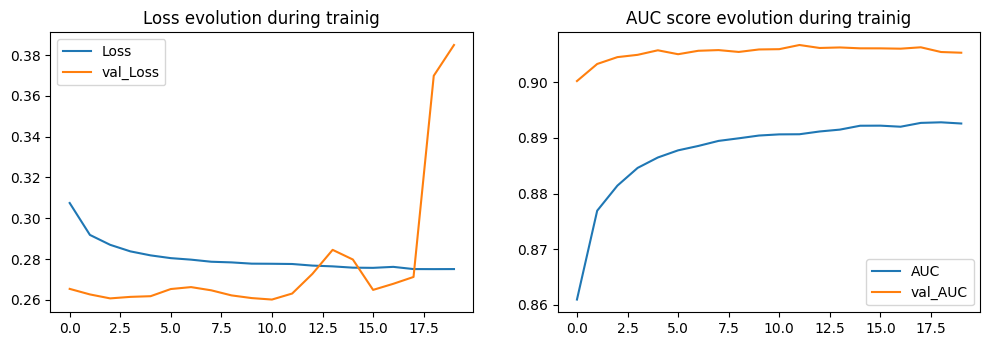

In [116]:
plot_learning_evolution(r)

In [117]:
y_train_pred = model.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), train=True)


# True Positives (TP): 209,197 - The model correctly predicted the positive class (e.g., "Charged Off").
# True Negatives (TN): 23,680 - The model correctly predicted the negative class (e.g., "Fully Paid").
# False Positives (FP): 27,985 - The model incorrectly predicted the positive class.
# False Negatives (FN): 1,281 - The model incorrectly predicted the negative class.


8192/8192 ━━━━━━━━━━━━━━━━━━━━ 6s 674us/step
Train Result:
Accuracy Score: 88.87%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.93      0.88      0.89       0.91          0.89
recall        0.47      0.99      0.89       0.73          0.89
f1-score      0.63      0.93      0.89       0.78          0.87
support   51665.00 210478.00      0.89  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 24373  27292]
 [  1881 208597]]



In [118]:
y_test_pred = model.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), train=False)


# Overall Accuracy: At around 89.3%, this suggests the model generally performs well across both classes.

4076/4076 ━━━━━━━━━━━━━━━━━━━━ 3s 679us/step
Test Result:
Accuracy Score: 88.88%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.92      0.89      0.89       0.90          0.89
recall        0.47      0.99      0.89       0.73          0.89
f1-score      0.62      0.93      0.89       0.78          0.87
support   25480.00 104943.00      0.89  130423.00     130423.00
_______________________________________________
Confusion Matrix: 
 [[ 12003  13477]
 [  1021 103922]]



In [119]:
scores_dict = {
    'ANNs': {
        'Train': roc_auc_score(y_train, model.predict(X_train)),
        'Test': roc_auc_score(y_test, model.predict(X_test)),
    },
}

8192/8192 ━━━━━━━━━━━━━━━━━━━━ 6s 706us/step
4076/4076 ━━━━━━━━━━━━━━━━━━━━ 3s 669us/step


In [ ]:
# In neural networks, especially in deep and complex models like ANNs, interpreting feature importance isn't as straightforward as it is with models like decision trees or random forests. 

In [ ]:
# RandomForest

In [121]:
param_grid = dict(
    n_estimators=stats.randint(100, 500),
    max_depth=stats.randint(10, 50),
    min_samples_split=stats.randint(2, 5),
    min_samples_leaf=stats.randint(1, 4),
)

rf_clf = RandomForestClassifier(n_estimators=100)
rf_cv = RandomizedSearchCV(
    rf_clf, param_grid, cv=3, n_iter=30, 
    scoring='roc_auc', n_jobs=-1, verbose=1
)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best Parameters: {best_params}")
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 414}
Train Result:
Accuracy Score: 94.43%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     1.00      0.94      0.94       0.97          0.95
recall        0.72      1.00      0.94       0.86          0.94
f1-score      0.84      0.97      0.94       0.90          0.94
support   51665.00 210478.00      0.94  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 37075  14590]
 [     0 210478]]

Test Result:
Accuracy Score: 88.93%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.97      0.88      0.89       0.93          0.90
recall        0.45      1.00      0.89       0.72          0.89
f1-sc

Best Parameters: {'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 414}
Train Result:
Accuracy Score: 94.36%
ROC-AUC Score: 0.8570
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83     51665
           1       0.93      1.00      0.97    210478

    accuracy                           0.94    262143
   macro avg       0.97      0.86      0.90    262143
weighted avg       0.95      0.94      0.94    262143

Confusion Matrix: 
 [[ 36886  14779]
 [     0 210478]] 

Test Result:
Accuracy Score: 88.92%
ROC-AUC Score: 0.7210
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.44      0.61     25480
           1       0.88      1.00      0.94    104943

    accuracy                           0.89    130423
   macro avg       0.93      0.72      0.77    130423
weighted avg       0.90      0.89      0.87    130423

Confusion Matrix: 
 [

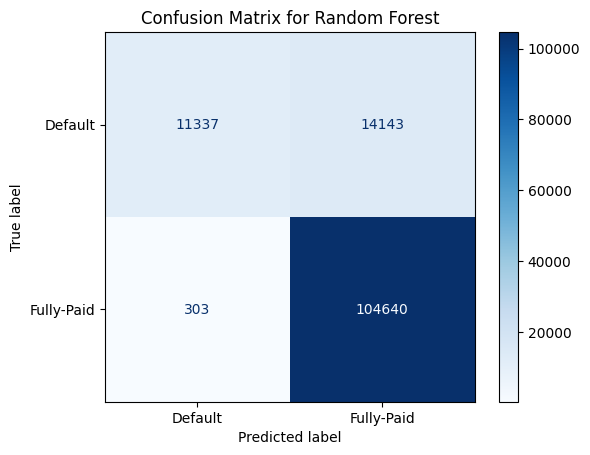

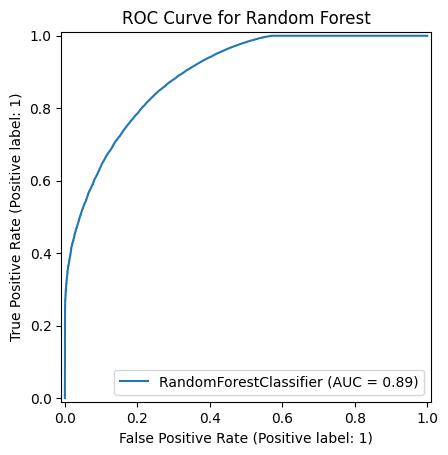

In [183]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Assuming 'X_train', 'X_test', 'y_train', 'y_test' are already defined
# and your Random Forest model is named 'rf_clf' and fitted

# Best Parameters from RandomizedSearchCV
best_params = rf_cv.best_params_
print(f"Best Parameters: {best_params}")

# Create and fit the classifier with best parameters
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

# Predicting on the training and test set
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

# Printing the score
def print_score(true, pred, train=True):
    if train:
        print("Train Result:\n================================================")
    else:
        print("Test Result:\n================================================")
    print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
    print(f"ROC-AUC Score: {roc_auc_score(true, pred):.4f}")
    print("Classification Report:\n", classification_report(true, pred))
    print("Confusion Matrix: \n", confusion_matrix(true, pred), "\n")

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, cmap='Blues', values_format='d', display_labels=['Default', 'Fully-Paid'])
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Display ROC Curve
disp = RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)
plt.title('ROC Curve for Random Forest')
plt.show()


In [184]:
column_names = ['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc',
                'loan_status', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
                'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'sub_grade_A2',
                'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
                'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
                'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
                'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
                'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
                'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
                'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
                'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
                'sub_grade_G5', 'verification_status_Source Verified',
                'verification_status_Verified', 'purpose_credit_card',
                'purpose_debt_consolidation', 'purpose_educational',
                'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
                'purpose_medical', 'purpose_moving', 'purpose_other',
                'purpose_renewable_energy', 'purpose_small_business',
                'purpose_vacation', 'purpose_wedding', 'initial_list_status_w',
                'application_type_INDIVIDUAL', 'application_type_JOINT',
                'home_ownership_MORTGAGE', 'home_ownership_NONE',
                'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
                'zip_code_05113', 'zip_code_11650', 'zip_code_22690', 'zip_code_29597',
                'zip_code_30723', 'zip_code_48052', 'zip_code_70466', 'zip_code_86630',
                'zip_code_93700', 'earliest_cr_line_year']


In [186]:
if 'loan_status' in column_names:
    column_names.remove('loan_status')

In [187]:

# Assuming X_train is your NumPy array
X_train_df = pd.DataFrame(X_train, columns=column_names)
print(X_train_df.head())

   loan_amnt  term  int_rate  installment  annual_inc  dti  open_acc  pub_rec  \
0       0.13  0.00      0.34         0.12        0.15 0.49      0.28     0.00   
1       0.36  0.00      0.09         0.30        0.47 0.11      0.18     0.00   
2       0.04  0.00      0.21         0.04        0.19 0.13      0.05     0.00   
3       0.52  1.00      0.40         0.32        0.90 0.20      0.21     0.01   
4       0.36  0.00      0.34         0.33        0.27 0.37      0.13     0.00   

   revol_bal  revol_util  total_acc  mort_acc  pub_rec_bankruptcies  \
0       0.03        0.41       0.51      0.06                  0.00   
1       0.07        0.25       0.37      0.12                  0.00   
2       0.03        0.63       0.41      0.08                  0.00   
3       0.04        0.50       0.44      0.16                  0.12   
4       0.05        0.76       0.13      0.00                  0.00   

   sub_grade_A2  sub_grade_A3  sub_grade_A4  sub_grade_A5  sub_grade_B1  \
0          

In [189]:
# Get feature importances from the RandomForest model
feature_importances = rf_clf.feature_importances_

# Creating a DataFrame to view the features and their importance scores
features_df = pd.DataFrame({
    'Feature': X_train_df.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Most Important Features:")
print(features_df.head(10))

Top 10 Most Important Features:
           Feature  Importance
78  zip_code_93700        0.13
71  zip_code_11650        0.13
77  zip_code_86630        0.13
2         int_rate        0.06
5              dti        0.05
9       revol_util        0.04
4       annual_inc        0.04
8        revol_bal        0.04
3      installment        0.04
0        loan_amnt        0.03


In [190]:
ml_models = {
    'Random Forest': rf_clf, 
    'ANNs': model
}

for model in ml_models:
    print(f"{model.upper():{30}} roc_auc_score: {roc_auc_score(y_test, ml_models[model].predict(X_test)):.3f}")

RANDOM FOREST                  roc_auc_score: 0.721
4076/4076 ━━━━━━━━━━━━━━━━━━━━ 3s 739us/step
ANNS                           roc_auc_score: 0.905
